In [2]:
!pip install statsmodels==0.14.0


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [3]:
pip install --upgrade statsmodels


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.stats as stats
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
df_crashes = pd.read_csv('aircraft_accidents.csv')
df_crashes

### Functions

In [5]:
def generate_metadata(dataframe):
    """
    Generates a DataFrame containing metadata for the columns of the provided DataFrame.

    :param dataframe: DataFrame for which metadata will be generated.
    :return: DataFrame containing metadata.
    """

    # Collection of basic metadata
    metadata = pd.DataFrame({
        'variable': dataframe.columns,
        'type': dataframe.dtypes,
        'null_count': dataframe.isnull().sum(),
        'null_percent': round((dataframe.isnull().sum() / len(dataframe))* 100,2),
        'cardinality': dataframe.nunique(),
    })
#     metadata = metadata.sort_values(by='type')
    metadata = metadata.reset_index(drop=True)

    return metadata

### Data Cleaning and Preprocessing

In [6]:
# Plot metadata for dataframe df_crashes
metadata_df = generate_metadata(df_crashes)
metadata_df

,variable,type,null_count,null_percent,cardinality
0,Year,int64,0,0.00,113
1,Quarter,object,0,0.00,4
2,Month,object,0,0.00,12
3,Day,int64,0,0.00,31
4,Country/Region,object,39,0.78,523
5,Aircraft Manufacturer,object,0,0.00,633
6,Aircraft,object,0,0.00,3520
7,Location,object,0,0.00,4165
8,Operator,object,0,0.00,2627
9,Sum of Ground,int64,0,0.00,50


In [7]:
# Rename columns to lowercase with underscores
df_crashes.columns = df_crashes.columns.str.lower().str.replace(' ', '_')

# Now, the column names have been changed to lowercase with underscores
print(df_crashes.columns)

Index(['year', 'quarter', 'month', 'day', 'country/region',
       'aircraft_manufacturer', 'aircraft', 'location', 'operator',
       'sum_of_ground', 'sum_of_fatalities_(air)', 'sum_of_aboard'],
      dtype='object')


In [8]:
# Replace "N/A" with NaN in the entire DataFrame
df_crashes.replace("N/A", np.nan, inplace=True)

# Drop rows with NaN values in any column
df_crashes.dropna(inplace=True)

In [9]:
# Plot metadata for dataframe df_crashes
metadata_df = generate_metadata(df_crashes)
metadata_df

,variable,type,null_count,null_percent,cardinality
0,year,int64,0,0.0,112
1,quarter,object,0,0.0,4
2,month,object,0,0.0,12
3,day,int64,0,0.0,31
4,country/region,object,0,0.0,508
5,aircraft_manufacturer,object,0,0.0,593
6,aircraft,object,0,0.0,3355
7,location,object,0,0.0,3899
8,operator,object,0,0.0,2583
9,sum_of_ground,int64,0,0.0,50


#### Trends Over Time:

* Analyze the trend in the number of crashes over the years, quarters, and months. Are there any seasonal patterns or trends?

In [10]:
# Assuming your dataset has a 'Year' column, convert it to a datetime object
# If the column name is different, replace 'Year' with the actual column name.
df_crashes['year'] = pd.to_datetime(df_crashes['year'], format='%Y')

# Extract the year from the 'Year' column
df_crashes['year'] = df_crashes['year'].dt.year

# Group the data by year and count the number of crashes per year
crashes_by_year = df_crashes['year'].value_counts().sort_index().reset_index()
crashes_by_year.columns = ['Year', 'Number of Crashes']

# Create a line plot using Plotly Express
fig = px.line(crashes_by_year, x='Year', y='Number of Crashes', title='Airplane Crashes Over the Years')
fig.update_xaxes(type='category')  # Ensure the x-axis treats years as categories

# Show the line plot
fig.show()

#### Fatalities and Survivors:

* Calculate the average and median number of fatalities and survivors per crash.
* Investigate whether there are any patterns or trends in the number of fatalities and survivors over time.

In [11]:
# Calculate the average number of fatalities and survivors per crash
average_fatalities_per_crash = df_crashes['sum_of_fatalities_(air)'].mean()
average_survivors_per_crash = df_crashes['sum_of_aboard'].mean()

# Calculate the median number of fatalities and survivors per crash
median_fatalities_per_crash = df_crashes['sum_of_fatalities_(air)'].median()
median_survivors_per_crash = df_crashes['sum_of_aboard'].median()


print(f"Average of Fatalities per Crash: {average_fatalities_per_crash}, \
\nAverage of Survivors per Crash: {average_survivors_per_crash}, \
\nMedian of Fatalities per Crash: {median_fatalities_per_crash}, \
\nMedian of Survivors per Crash: {median_survivors_per_crash}")

Average of Fatalities per Crash: 22.35514411950347, 
Average of Survivors per Crash: 31.102251209762255, 
Median of Fatalities per Crash: 11.0, 
Median of Survivors per Crash: 16.0


In [12]:
# Map month names to numerical values
month_map = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

# Convert month names to numerical values
df_crashes['month'] = df_crashes['month'].map(month_map)

# Convert date columns (year, month, day) to a single datetime column for time series analysis
df_crashes['date'] = pd.to_datetime(df_crashes[['year', 'month', 'day']])

# Group data by year and sum the number of fatalities and survivors for each year
yearly_stats = df_crashes.groupby('year')[['sum_of_fatalities_(air)', 'sum_of_aboard', 'sum_of_ground']].sum().reset_index()

# Create an interactive line chart with Plotly Express
fig = px.line(yearly_stats, x='year', y=['sum_of_fatalities_(air)', 'sum_of_aboard', 'sum_of_ground'],
              labels={'year': 'Year', 'value': 'Number of Fatalities'},
              title='Trends in Fatalities and Survivors Over Time')
fig.update_traces(mode='markers+lines')

# Show the interactive plot
fig.show()

#### Aircraft Manufacturer and Type:

* Identify the most common aircraft manufacturers and aircraft types involved in crashes.
* Analyze whether certain manufacturers or types are associated with a higher number of crashes.

In [13]:
# Group the data by 'aircraft_manufacturer' and count the number of occurrences
manufacturer_counts = df_crashes['aircraft_manufacturer'].value_counts()

# Get the top N most common manufacturers (e.g., top 10)
top_manufacturers = manufacturer_counts.head(10)

# Print the results
print("Top Aircraft Manufacturers Involved in Crashes:")
print(top_manufacturers)


Top Aircraft Manufacturers Involved in Crashes:
Douglas                946
Boeing                 375
Antonov                263
Lockheed               201
de Havilland Canada    149
Ilyushin               132
Fokker                 120
McDonnell Douglas      120
Curtiss                118
De Havilland           105
Name: aircraft_manufacturer, dtype: int64


In [14]:
# Group the data by 'aircraft' and count the number of occurrences
aircraft_type_counts = df_crashes['aircraft'].value_counts()

# Get the top N most common aircraft types (e.g., top 10)
top_aircraft_types = aircraft_type_counts.head(10)

# Print the results
print("\nTop Aircraft Types Involved in Crashes:")
print(top_aircraft_types)


Top Aircraft Types Involved in Crashes:
Boeing B 737              73
Boeing B 727              55
Boeing B 707              50
McDonnell Douglas DC 9    39
Douglas C 47A             38
Britten  Norman BN        36
McDonnell Douglas DC 8    35
Boeing B 747              27
Douglas DC 3PP            23
Douglas DC 3 (C           23
Name: aircraft, dtype: int64


In [15]:
# Group the data by 'aircraft_manufacturer' and count the number of occurrences
manufacturer_counts = df_crashes['aircraft_manufacturer'].value_counts()

# Get the manufacturers with a sufficient number of crashes (e.g., more than 10)
min_crash_threshold = 10
common_manufacturers = manufacturer_counts[manufacturer_counts >= min_crash_threshold].index

# Filter the DataFrame to include only the common manufacturers
filtered_df = df_crashes[df_crashes['aircraft_manufacturer'].isin(common_manufacturers)]

# Create a contingency table for hypothesis testing
contingency_table = pd.crosstab(filtered_df['aircraft_manufacturer'], filtered_df['sum_of_fatalities_(air)'])

# Perform a chi-square test of independence
chi2, p, _, _ = stats.chi2_contingency(contingency_table)

# Print the results
print(f"Chi-squared test statistic: {chi2}")
print(f"P-value: {p}")

# Interpret the results
alpha = 0.05  # Significance level
if p < alpha:
    print("There is a statistically significant association between manufacturers and fatalities.")
else:
    print("There is no statistically significant association between manufacturers and fatalities.")

Chi-squared test statistic: 8784.170065790551
P-value: 1.0
There is no statistically significant association between manufacturers and fatalities.


In [16]:
# Group the data by 'aircraft' and count the number of occurrences
aircraft_type_counts = df_crashes['aircraft'].value_counts()

# Get the aircraft types with a sufficient number of crashes (e.g., more than 10)
min_crash_threshold = 10
common_aircraft_types = aircraft_type_counts[aircraft_type_counts >= min_crash_threshold].index

# Filter the DataFrame to include only the common aircraft types
filtered_df = df_crashes[df_crashes['aircraft'].isin(common_aircraft_types)]

# Create a contingency table for hypothesis testing
contingency_table = pd.crosstab(filtered_df['aircraft'], filtered_df['sum_of_fatalities_(air)'])

# Perform a chi-square test of independence
chi2, p, _, _ = stats.chi2_contingency(contingency_table)

# Print the results
print(f"Chi-squared test statistic: {chi2}")
print(f"P-value: {p}")

# Interpret the results
alpha = 0.05  # Significance level
if p < alpha:
    print("There is a statistically significant association between aircraft types and fatalities.")
else:
    print("There is no statistically significant association between aircraft types and fatalities.")

Chi-squared test statistic: 4304.523632458486
P-value: 0.9999999999999997
There is no statistically significant association between aircraft types and fatalities.


#### Location Analysis:

* Explore the locations where crashes occurred. Are there specific airports, cities, or regions with a higher crash frequency?

In [17]:
# Group the data by 'location' and count the number of occurrences
location_counts = df_crashes['location'].value_counts().reset_index()
location_counts.columns = ['Location', 'Crash Count']

# Get the top N locations with the highest crash frequency (e.g., top 10)
top_locations = location_counts.head(10)

# Create an interactive bar chart using Plotly Express
fig = px.bar(top_locations, x='Location', y='Crash Count',
             labels={'Location': 'Location', 'Crash Count': 'Crash Count'},
             title='Top Locations with Highest Crash Frequency')
fig.update_xaxes(categoryorder='total descending')  # Sort x-axis by crash count

# Show the interactive plot
fig.show()

#### Operator Analysis:

* Determine which operators have been involved in the most crashes.
* Investigate whether there are any patterns related to the operators, such as changes in safety records over time.

In [18]:
df_crashes.dropna(subset=['operator'], inplace=True)

# Group the data by 'operator' and count the number of occurrences
operator_counts = df_crashes['operator'].value_counts().reset_index()
operator_counts.columns = ['Operator', 'Crash Count']

# Get the top N operators with the highest crash frequency (e.g., top 10)
top_operators = operator_counts.head(10)

# Create an interactive bar chart using Plotly Express
fig = px.bar(top_operators, x='Operator', y='Crash Count',
             labels={'Operator': 'Operator', 'Crash Count': 'Crash Count'},
             title='Top Operators Involved in the Most Crashes')
fig.update_xaxes(categoryorder='total descending')  # Sort x-axis by crash count

# Show the interactive plot
fig.show()

#### Ground Casualties:

* Analyze the number of ground casualties and determine if there are any significant incidents involving ground casualties.

In [19]:
# Summary statistics of ground casualties
ground_casualties_stats = df_crashes['sum_of_ground'].describe()

# Print summary statistics
print(ground_casualties_stats)


count    4753.000000
mean        1.803913
std        56.714996
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      2750.000000
Name: sum_of_ground, dtype: float64


#### Time Series Analysis:

* Use time series analysis techniques to identify trends, seasonality, and potential outliers in the data.

In [20]:
fig = px.line(df_crashes, x=df_crashes.date, y=['sum_of_fatalities_(air)', 'sum_of_aboard', 'sum_of_ground'],
              labels={'x': 'Date', 'y': 'Number of Incidents'},
              title='Trends in Fatalities and Survivors Over Time')

fig.update_traces(mode='lines+markers')
fig.show()

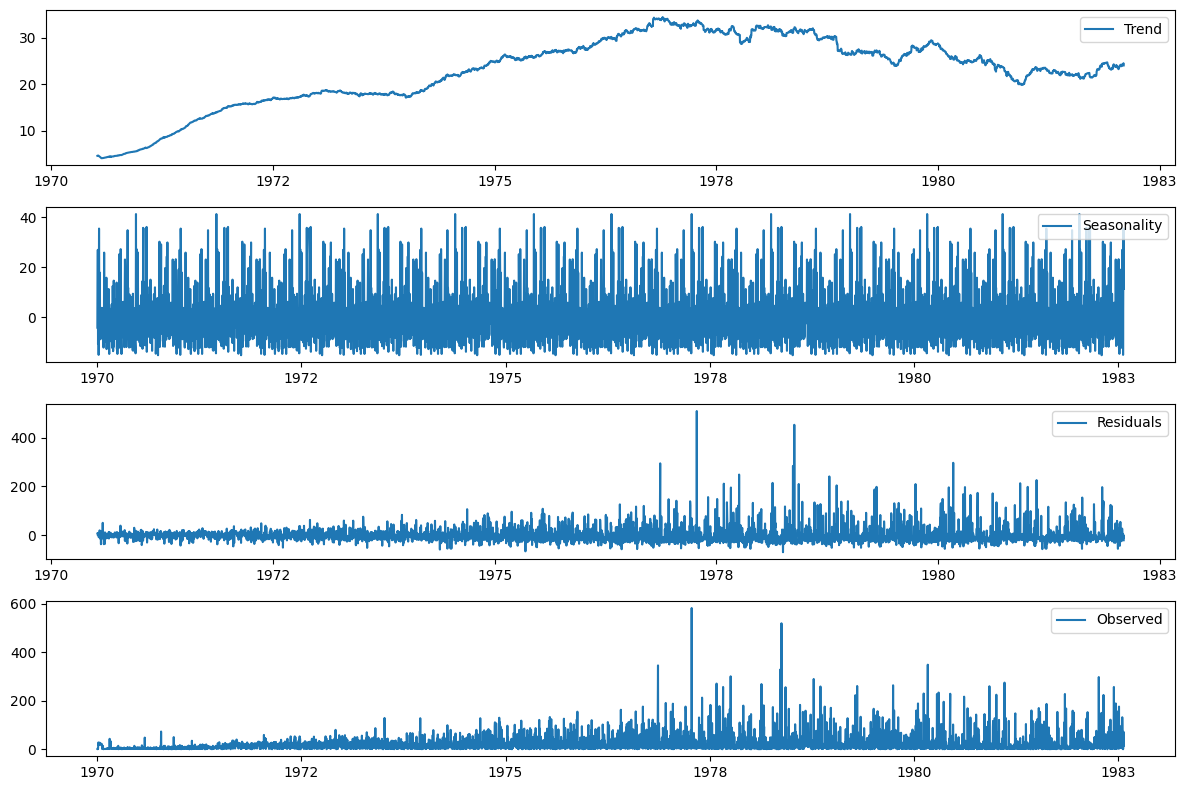

In [27]:
# Perform seasonal decomposition
result_fatalities = seasonal_decompose(df_crashes['sum_of_fatalities_(air)'], model='additive', period=365)  # Set period if data is daily
result_survivors = seasonal_decompose(df_crashes['sum_of_aboard'], model='additive', period=365)

# Plot the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(result_fatalities.trend.index, result_fatalities.trend, label='Trend')
plt.legend()
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))  # Format x-axis as years

plt.subplot(412)
plt.plot(result_fatalities.seasonal.index, result_fatalities.seasonal, label='Seasonality')
plt.legend()
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))  # Format x-axis as years

plt.subplot(413)
plt.plot(result_fatalities.resid.index, result_fatalities.resid, label='Residuals')
plt.legend()
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))  # Format x-axis as years

plt.subplot(414)
plt.plot(result_fatalities.observed.index, result_fatalities.observed, label='Observed')
plt.legend()
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))  # Format x-axis as years

plt.tight_layout()
plt.show()


/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

                                  SARIMAX Results                                  
Dep. Variable:     sum_of_fatalities_(air)   No. Observations:                 4753
Model:                      ARIMA(0, 1, 0)   Log Likelihood              -25183.433
Date:                     Thu, 05 Oct 2023   AIC                          50368.867
Time:                             04:20:10   BIC                          50375.333
Sample:                                  0   HQIC                  

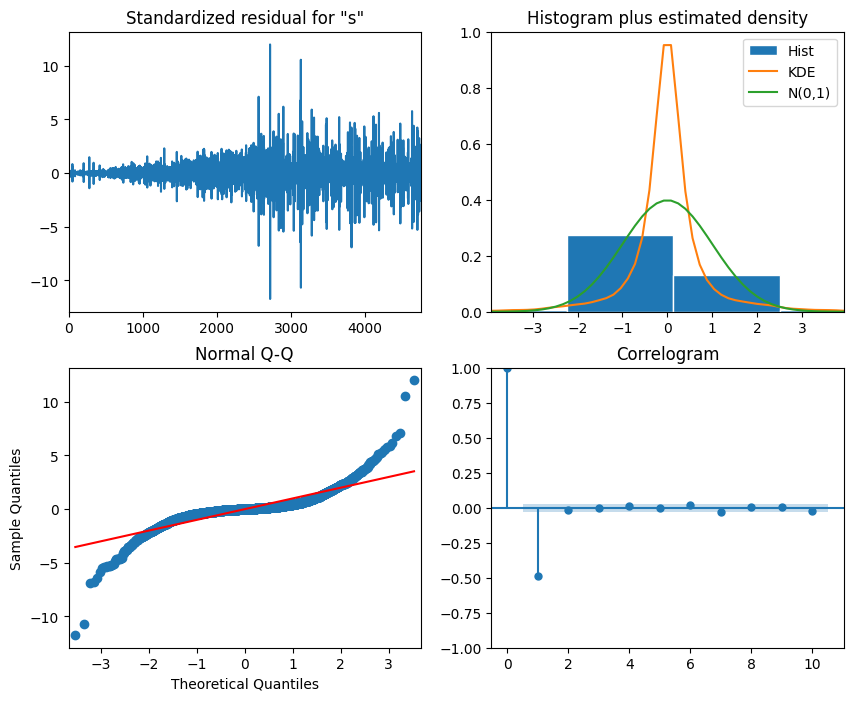

In [26]:
# Define values for p, d, and q
p = 0  # Autoregressive order
d = 1  # Differencing order
q = 0  # Moving average order

# Fit an ARIMA model to the data
model = ARIMA(df_crashes['sum_of_fatalities_(air)'], order=(p, d, q))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

# Plot model diagnostics
model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ce1aefcf-e1bb-4f04-bb8a-125b6f32580a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>